In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from salt_utils import get_train_test_salt_data
from unet import UNet
import matplotlib.pyplot as plt
from dotted.collection import DottedDict
from pyfastnoisesimd import generate
import numpy as np
import pickle
import random
from random import uniform, randint
import tqdm

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  
def plot_metrics(metric_logs, ylim=None):
  for metric_log in metric_logs:
    plt.plot(metric_log['epoch'], metric_log['metric'], label=metric_log['label'])
  plt.xlabel('Epochs')
  plt.ylabel('Metric')
  if ylim is not None: plt.ylim(*ylim)
  plt.legend()
  plt.show()
  
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return 1.0 - (((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth)))
  
def train(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.net.train()
    for img, mask in model.loader:
      model.img_cuda.copy_(img)
      del img
      model.mask_cuda.copy_(mask)
      del mask
      model.optimizer.zero_grad()
      prediction = model.net(model.img_cuda)
      loss =  dice_loss(F.sigmoid(prediction), model.mask_cuda) * 100
      metric += loss.item()
      samples_seen += model.batch_size
      loss.backward()
      model.optimizer.step()
      model.scheduler.step()
    model.train_metric_log['epoch'].append(model.epochs_trained)
    model.train_metric_log['metric'].append(metric / samples_seen)
    
    if model.epochs_trained % model.eval_test == 0:
      metric = 0
      samples_seen = 0
      model.net.eval()
      with torch.no_grad():
        for img, mask in model.loader_test:
          model.img_cuda.copy_(img)
          del img
          model.mask_cuda.copy_(mask)
          del mask
          prediction = model.net(model.img_cuda)
          loss = dice_loss(F.sigmoid(prediction), model.mask_cuda) * 100
          metric += loss.item()
          samples_seen += model.batch_size
      model.test_metric_log['epoch'].append(model.epochs_trained)
      model.test_metric_log['metric'].append(metric / samples_seen)
    model.epochs_trained += 1

def generate_noise():
  return fns.generate(size=[1, 128, 128], noiseType='Perlin',
                      freq=uniform(.01, .075), seed=randint(0, 100000))[0]
    
def interpolate(a, b, f):
  return (a * (1.0 - f)) + (b * f)
    
def train_mixup(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.net.train()
    for (img_a, mask_a), (img_b, mask_b) in zip(model.loader, model.loader_other):
      mixup_lerp = random.random()
      model.img_cuda.copy_(interpolate(img_a, img_b, mixup_lerp))
      del img_a; del img_b
      model.mask_cuda.copy_(interpolate(mask_a, mask_b, mixup_lerp))
      del mask_a; del mask_b
      model.optimizer.zero_grad()
      prediction = model.net(model.img_cuda)
      loss = dice_loss(F.sigmoid(prediction), model.mask_cuda) * 100
      metric += loss.item()
      samples_seen += model.batch_size
      loss.backward()
      model.optimizer.step()
      model.scheduler.step()
    model.train_metric_log['epoch'].append(model.epochs_trained)
    model.train_metric_log['metric'].append(metric / samples_seen)
    
    if model.epochs_trained % model.eval_test == 0:
      metric = 0
      samples_seen = 0
      model.net.eval()
      with torch.no_grad():
        for img, mask in model.loader_test:
          model.img_cuda.copy_(img)
          del img
          model.mask_cuda.copy_(mask)
          del mask
          prediction = model.net(model.img_cuda)
          loss = (F.binary_cross_entropy_with_logits(prediction, model.mask_cuda) +
                  dice_loss(F.sigmoid(prediction), model.mask_cuda)) * 100
          metric += loss.item()
          samples_seen += model.batch_size
      model.test_metric_log['epoch'].append(model.epochs_trained)
      model.test_metric_log['metric'].append(metric / samples_seen)
    model.epochs_trained += 1
  
def weights_init(m):
  with torch.no_grad():
    if isinstance(m, nn.Conv2d):
      torch.nn.init.xavier_uniform_(m.weight)
      
def pickle_model(model, file):
  pickle.dump({
    'class': UNet,
    'trained_model': model.net.state_dict(),
    'optimizer': model.optim,
    'epochs_trained': model.epochs_trained,
    'train_metric_log': model.train_metric_log,
    'test_metric_log': model.test_metric_log,
  }, open(file, 'wb'))

In [52]:
train_data, test_data = get_train_test_salt_data('./data/train/images/', 
                                                 './data/train/masks/', 
                                                 './data/train/depths.csv', 
                                                 test_frac=.2)
model = DottedDict()
model['seed'] = 200
set_seed(model.seed)
model['batch_size'] = 48
model['net'] = UNet().cuda()
model.net.apply(weights_init)
model['optimizer'] = optim.Adam(model.net.parameters(), lr=0.025)
model['scheduler'] = optim.lr_scheduler.CosineAnnealingLR(model.optimizer, len(train_data) * 2, .0005)
model['loader'] = DataLoader(train_data, model.batch_size, True, num_workers=4, drop_last=True, pin_memory=True)
model['loader_other'] = DataLoader(train_data, model.batch_size, True, num_workers=4, drop_last=True, pin_memory=True)
model['loader_test'] = DataLoader(test_data, model.batch_size, True, num_workers=4, drop_last=True, pin_memory=True)
model['img_cuda'] = torch.empty([model.batch_size, 2, 128, 128]).cuda()
model['mask_cuda'] = torch.empty([model.batch_size, 1, 128, 128]).cuda()
model['epochs_trained'] = 0
model['eval_test'] = 1
model['train_metric_log'] = {'label':'Train Loss', 'epoch':[], 'metric':[]}
model['test_metric_log'] = {'label':'Test Loss', 'epoch':[], 'metric':[]}

In [171]:
import pickle
no_mixup_hist = pickle.load(open('./history/no_mixup_256_epoch1000.hist', 'rb'))
no_mixup_hist['train_metric_log']['label'] = 'Standard Train Loss'
no_mixup_hist['test_metric_log']['label'] = 'Standard Test Loss'

mixup_hist = pickle.load(open('./history/mixup_256_epoch1000.hist', 'rb'))
mixup_hist['train_metric_log']['label'] = 'Mixup Train Loss'
mixup_hist['test_metric_log']['label'] = 'Mixup Test Loss'

noisy_mixup_hist = pickle.load(open('./history/noisy_mixup_256_epoch1000.hist', 'rb'))
noisy_mixup_hist['train_metric_log']['label'] = 'Noisy Mixup Train Loss'
noisy_mixup_hist['test_metric_log']['label'] = 'Noisy Mixup Test Loss'

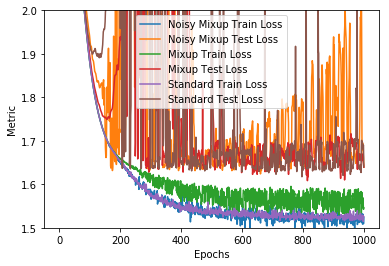

In [174]:
plot_metrics(list(noisy_mixup_hist.values()) + list(mixup_hist.values()) + list(no_mixup_hist.values()), ylim=(1.5, 2))

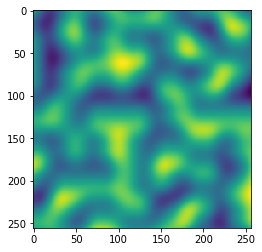

In [179]:
import matplotlib.pyplot as plt
#(.01, .075).001
plt.imshow(fns.generate(size=[1, 256, 256], noiseType='Perlin',
                        freq=.05, seed=randint(0, 100000))[0])

In [185]:
def Conv(in_c, out_c):
  return nn.Sequential(
    nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
    nn.ELU(inplace=True),
    nn.BatchNorm2d(out_c),
    nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
    nn.ELU(inplace=True),
    nn.BatchNorm2d(out_c),
  )

class UpConv(nn.Module):
  def __init__(self, in_c, out_c):
    super(UpConv, self).__init__()
    self.upsample = F.max_pool2d
    self.conv = Conv(in_c, out_c)
  
  def forward(self, below, left, below_left=None):
    x = [left, self.upsample(below)]
    if below_left is not None: x.append(self.upsample(below_left))
    return self.conv(torch.cat(x, dim=1))

class TangledUNet64(nn.Module):
  def __init__(self):
    super(TangledUNet64, self).__init__()
    self.down0 = Conv(  3,  16) # (  3,  64,  64) --> ( 16,  64,  64)
    self.down1 = Conv( 16,  32) # ( 16,  32,  32) --> ( 32,  32,  32)
    self.down2 = Conv( 32,  64) # ( 32,  16,  16) --> ( 64,  16,  16)
    self.down3 = Conv( 64, 128) # ( 64,   8,   8) --> (128,   8,   8)
    self.up0 = UpConv(192,  64) # (192,  16,  16) --> ( 64,  16,  16)
    self.up1 = UpConv(160,  32) # (160,  32,  32) --> ( 32,  32,  32)
    self.up2 = UpConv( 80,  16) # (160,  64,  64) --> ( 16,  64,  64)
    self.tail = nn.Conv2d(16, 1, 1)
    
  def forward(self, x):
    down016_64 = self.down0(x)
    down032_32 = self.down1(down016_64)
    down064_16 = self.down2(down032_32)
    down128_08 = self.down3(down064_16)
    up = self.up0(down128_08, down064_16)
    up = self.up1(up, down032_32, down064_16)
    up = self.up2(up, down016_64, down032_32)
    return self.tail(up)

In [181]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SkippyUNet256(nn.Module):
  def __init__(self):
    super(UNet256, self).__init__()
    self.down1 = conv(  3,  16) # (  3, 256, 256) --> ( 16, 256, 256)
    self.down2 = conv( 16,  32) # ( 16, 128, 128) --> ( 32, 128, 128)
    self.down3 = conv( 32,  64) # ( 32,  64,  64) --> ( 64,  64,  64)
    self.down4 = conv( 64, 128) # ( 64,  32,  32) --> (128,  32,  32)
    self.down5 = conv(128, 256) # (128,  16,  16) --> (256,  16,  16)
    self.down6 = conv(256, 512) # (256,   8,   8) --> (512,   8,   8)
    self.up1   = conv(768, 256) # (768,  16,  16) --> (256,  16,  16)
    self.up2   = conv(384, 128) # (384,  32,  32) --> (128,  32,  32)
    self.up3   = conv(192,  64) # (192,  64,  64) --> ( 64,  64,  64)
    self.up4   = conv( 96,  32) # ( 32, 128, 128) --> ( 16, 128, 128)
    self.up5   = conv( 48,  16) # ( 32, 256, 256) --> ( 16, 256, 256)
    self.tail  = nn.Conv2d(16, 1, 1)
    self.downpool = nn.MaxPool2d(kernel_size=2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

  def forward(self, x):
    x_down_512 = self.down1(x)
    x_down_256 = self.down2(self.downpool(x_down_512))
    x_down_128 = self.down3(self.downpool(x_down_256))
    x_down_64  = self.down4(self.downpool(x_down_128))
    x_down_32  = self.down5(self.downpool(x_down_64))
    x_down_16  = self.down6(self.downpool(x_down_32))
    x_up = self.up1(torch.cat([self.upsample(x_down_16), x_down_32], dim=1))
    x_up = self.up2(torch.cat([self.upsample(x_up), x_down_64], dim=1))
    x_up = self.up3(torch.cat([self.upsample(x_up), x_down_128], dim=1))
    x_up = self.up4(torch.cat([self.upsample(x_up), x_down_256], dim=1))
    x_up = self.up5(torch.cat([self.upsample(x_up), x_down_512], dim=1))
    return self.tail(x_up)

class UNet256(nn.Module):
  def __init__(self):
    super(UNet256, self).__init__()
    self.down1 = conv(  3,  16) # (  3, 256, 256) --> ( 16, 256, 256)
    self.down2 = conv( 16,  32) # ( 16, 128, 128) --> ( 32, 128, 128)
    self.down3 = conv( 32,  64) # ( 32,  64,  64) --> ( 64,  64,  64)
    self.down4 = conv( 64, 128) # ( 64,  64,  64) --> (128,  32,  32)
    self.down5 = conv(128, 256) # (128,  16,  16) --> (256,  16,  16)
    self.down6 = conv(256, 512) # (256,   8,   8) --> (512,   8,   8)
    self.up1   = conv(768, 256) # (768,  16,  16) --> (256,  16,  16)
    self.up2   = conv(384, 128) # (384,  32,  32) --> (128,  32,  32)
    self.up3   = conv(192,  64) # (192,  64,  64) --> ( 64,  64,  64)
    self.up4   = conv( 96,  32) # ( 32, 128, 128) --> ( 16, 128, 128)
    self.up5   = conv( 48,  16) # ( 32, 256, 256) --> ( 16, 256, 256)
    self.tail  = nn.Conv2d(16, 1, 1)
    self.downpool = nn.MaxPool2d(kernel_size=2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

  def forward(self, x):
    x_down_512 = self.down1(x)
    x_down_256 = self.down2(self.downpool(x_down_512))
    x_down_128 = self.down3(self.downpool(x_down_256))
    x_down_64  = self.down4(self.downpool(x_down_128))
    x_down_32  = self.down5(self.downpool(x_down_64))
    x_down_16  = self.down6(self.downpool(x_down_32))
    x_up = self.up1(torch.cat([self.upsample(x_down_16), x_down_32], dim=1))
    x_up = self.up2(torch.cat([self.upsample(x_up), x_down_64], dim=1))
    x_up = self.up3(torch.cat([self.upsample(x_up), x_down_128], dim=1))
    x_up = self.up4(torch.cat([self.upsample(x_up), x_down_256], dim=1))
    x_up = self.up5(torch.cat([self.upsample(x_up), x_down_512], dim=1))
    return self.tail(x_up)

In [180]:
1e-4

0.0001